In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

### Evaluating function gradient numerically

In [2]:
def func(x):
    return x**2

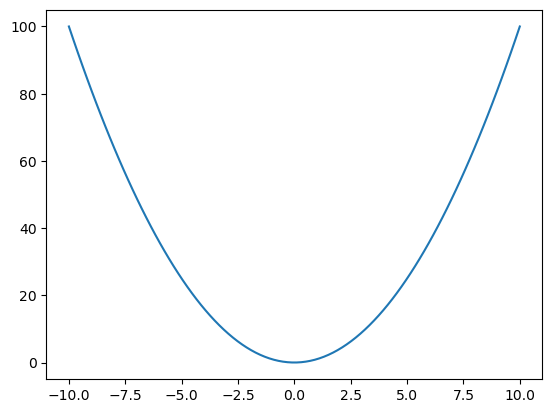

In [3]:
plt.plot(np.linspace(-10, 10, 100), func(np.linspace(-10, 10, 100)))

Calculating gradients analitically is problematic as with growing number of the networks layers the derivative would've been massive. That is why the gradient is calculated with the definition of derivative and numerical approximation.

In [4]:
def approx_derivative(f, x, eps=1e-5):
    return (f(x + eps) - f(x)) / eps

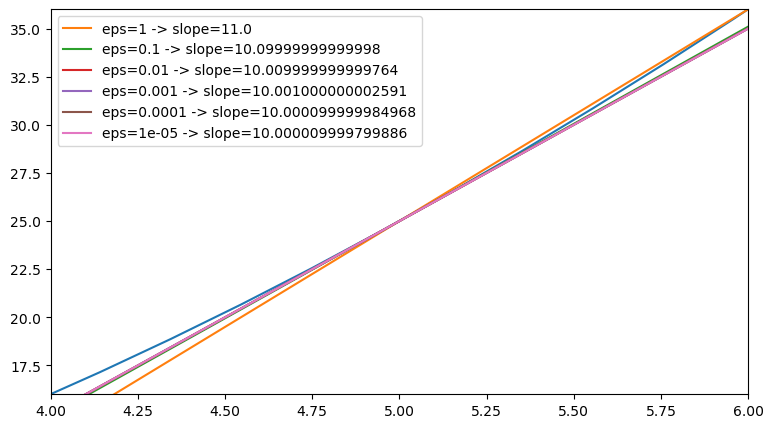

In [5]:
def get_b(slope, x, f):
    return f(x) - slope * x

plt.figure(figsize=(9, 5))
plt.plot(np.linspace(-10, 10, 100), func(np.linspace(-10, 10, 100)))
for eps in [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]:
    slope = approx_derivative(func, 5, eps)
    plt.plot(np.linspace(-10, 10, 100), slope * np.linspace(-10, 10, 100) + get_b(slope, 5, func), label=f"eps={eps} -> slope={slope}")

plt.xlim(4, 6)
plt.ylim(func(4), func(6))
plt.legend()

Just like the formal definition states: we approach the derivative bringing the epsilon towards 0. Gotta be careful with the magnitude of epsilon as too many zeros will result in a floating point error and give an incorrect result.

We can also compare the results to the analitical solution. The derivative of $x^2$ is $2x$ so $f'(5)=2*5=10$, we are pretty close.

### But how does this translate to NNs?

In [23]:
class Value:
    def __init__(self, data, _children=(), _op='', label='') -> None:
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0

    def __repr__(self) -> str:
        return f"Values(data={self.data})"
    
    def __add__(self, other):
        return Value(self.data + other.data, (self, other), "+")

    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), "*")
    
Value(6), Value(6) + Value(10), Value(6) * Value(10)

(Values(data=6), Values(data=16), Values(data=60))

Using the code provided in **The spelled out intro to neural networks [...]** we can plot the graphs of the Value class.

In [24]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [25]:
c = Value(6, label="a") * Value(10, label="b")
c.label = "c"
d = c + Value(10, label="d")
d.label = "d"
d

Values(data=70)

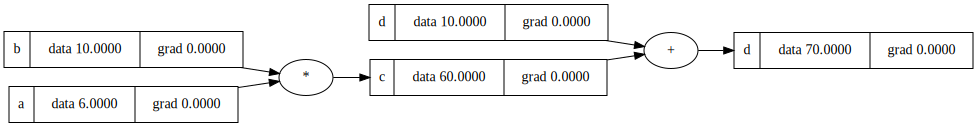

In [26]:
draw_dot(d)